<a href="https://colab.research.google.com/github/franzis17/EnronEmailAnalysis/blob/main/Development_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

## Initialise all packages needed in the program
Packages used:
* calendar --> 
* matplotlib --> for visualisation purposes. Plot the data in to some kind of a chart.
* pandas --> for efficiently sorting different kinds of data (i.e. sorting messages data in a monthly order)
* sqlite3 --> for extracting data in the database and perform 3 different kinds of analysis on the data

In [ ]:
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import re  # regular expression
import sqlite3
from wordcloud import WordCloud

# Generate Stopwords
from google.colab import output
!curl -Ol https://raw.githubusercontent.com/michael-borck/isys2001-worksheets/main/stopwords.py
output.clear()
print("Required packages installed")

## Connect to the database


In [ ]:
# Connect to the database using 'sqlite3'
conn = sqlite3.connect('/content/drive/MyDrive/a-quick_uploads/enron.db')

# Create a cursor to navigate each rows in the database and query any specific data from the dataset
cur = conn.cursor()

# Functions

* MUST run the following functions before any analysis.
* The functions below are modules, which is used by multiple analysis methods to decrease code repetition.

In [ ]:
def query_db_for_messages():
    # Query database for all messages and returns a dataframe containing all messages
    sql='''
    SELECT * FROM message
    '''
    return pd.read_sql(sql, conn)

def query_db_for_employees():
    sql='''
    SELECT * FROM employeelist
    '''
    return pd.read_sql(sql, conn)

# <u>**Analysis 1.**</u> Email Traffic Over Time

Aim: Analyze the volume of emails sent over time by counting the number of messages of each employees sent per month.

## **Problem:**
* Must count the total number of messages of all employees they are sending per month.

## **Inputs:**
* List of messages

## **Outputs:**
* A line chart that shows the number of emails per month. (x = month, y = number of emails(messages))

## **Algorithm:**
  1. Create a dataframe based on an SQL statement that obtains all messages from the database table "message".
  2. Using the "message" dataframe, use the total amount of messages of the dataframe to sort the data monthly.
  3. Using the monthly-sorted messages data, create a line chart that shows the total amount of messages per month.

* **Important**: Must close the connection to the SQLite Database when done with the database.

## **Python Implementation:**

In [ ]:
'''
Note:
> Lines 12 to 21 were generated by ChatGPT. More info on reference list [ChatGPT-1]
'''

messages_df = query_db_for_messages()

# Make a new month table to group each messages by year
messages_df['date'] = pd.to_datetime(messages_df['date'], errors='coerce')
messages_df['year'] = messages_df['date'].dt.year
messages_per_year = messages_df.groupby('year').size()

messages_per_year.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of messages per year')
plt.title('Total Number of Messages Per Year')
plt.show()

# **Analysis 2.** Top Senders and Receivers
Aim: Identify the most frequent email senders and recipients by aggregating(collecting) the data in the 'Message' and 'RecipientInfo' tables.

## **Problems:**
* Must find the most frequent email senders
* Must find the most frequent email receivers

## **Inputs:**
* Dataset of all senders from the "message" database table
* Dataset of all receivers from the "recipientinfo" database table

## **Outputs:**
* A set of all the most frequent email senders
* A set of all the most frequent email receivers

## **Algorithm:**

Finding the most frequent email <b>senders</b>:
1. Get all the messages from the database
2. Compute which "sender" has the most count and put it all on a data set sorted from highest to lowest email sent
3. Using the sorted data set, plot it all on a bar chart with: x = a number of emails and y = employee names

Finding the most frequent email <b>receivers</b>:
1. Get all the recepientinfo dataset from the database
2. Compute which "recepient" has the most count and put it all on a data set sorted from highest to lowest received email
3. Using the sorted data set, plot it all on a bar chart with: x = number of emails and y = employee name

## **Python Implementation:**

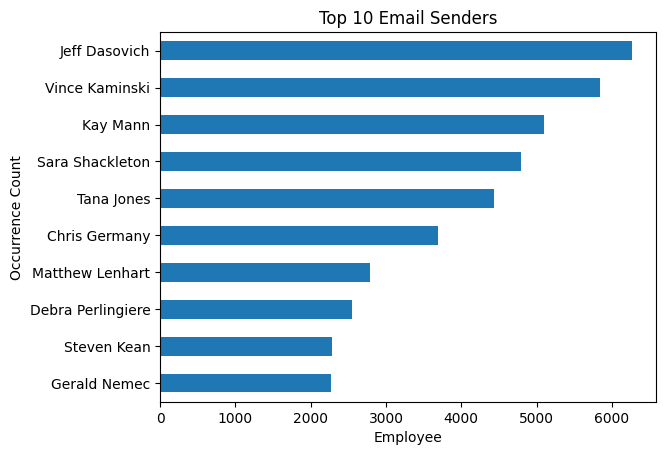

In [91]:
# Obtain all messages from the database
messages_df = query_db_for_messages()
employees_df = query_db_for_employees()

### sender_counts are a set of email, now find the name of the employee based on these email set

merged_df = messages_df.merge(employees_df, left_on='sender', right_on='Email_id', how='right')

# Combine firstName and lastName to full name
merged_df['fullName'] = merged_df['firstName'] + ' ' + merged_df['lastName']
employee_counts = merged_df['fullName'].value_counts()
top_employees = employee_counts.head(10)

# Plot to Bar Chart
top_employees.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Employee')
plt.ylabel('Occurrence Count')
plt.title('Top 10 Email Senders')
plt.show()

# **Analysis 3.** Subject Keyword Analysis
Aim: Extract keywords from email subjects in the 'Message' table and analyze the frequency of words used to understand common topics of discussion.

## Problem:

* Must understand the common topics of discussion from the dataset of 'Message' table to see if it is related to any potential fraudulent activities.

## Inputs:

* List of words from the subject section of all email email messages. (database table located in message.subject)

## Outputs:

* WordCloud that shows the most common words used in the subject section of the email with. (Frequency of words depends on the size, i.e. large-sized words are most frequently used and smaller-sized are less frequent.)

# Algorithm:
  1. Extract all dataset of 'Message' table.
  2. Clean the 'subject' contents of the message dataset to only contain absolute words (words must not contain any symbols/numbers)
  3. Generate list of stop words called "ENGLISH_STOP_WORDS" from Stopwords.py, which is a list of words that do not provide much meaning to the analysis.
  4. Create a WordCloud using the "Cleaned-subject" list of words.

In [ ]:
from stopwords import ENGLISH_STOP_WORDS

# Ref. [2]
def clean(text):
    ''' Uses regular expresison to extract english letter and digits from the supplied text. '''
    regExp = "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"
    return ' '.join(re.sub(regExp, " ", text).split())


# no need to extract messages from the database assuming it has been extracted from Analysis 1

# Create a new column as a placeholder for the clean subject keywords
messages_df['Clean Subject'] = messages_df['subject'].apply(clean)

# Add additional words to stopwords that do not have much meaning
additional_stop_words = {'Enron', 'Market', 'Power'}
ENGLISH_STOP_WORDS.update(additional_stop_words)

# Create and Display the wordcloud
subjects = ' '.join(messages_df['Clean Subject'])
wordcloud = WordCloud(width=680, height=480, margin=0, stopwords=ENGLISH_STOP_WORDS).generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# Miscellaneous Database Operations (Not a part of Analysis)
Purpose = to get details about the database


### View Database Schema
In other words ==> View the all database tables existing in the database

In [ ]:
sql='''
SELECT name FROM sqlite_master WHERE type='table';
'''
cur.execute(sql)
cur.fetchall()

### View contents of a database table

In [ ]:
# Get all messages
sql='''
SELECT * FROM message
'''
messages_df = pd.read_sql(sql, conn)

# Sort the date to monthly amount of messages in the year 2000
idx = pd.date_range(start='2000', end='2001', freq='M')
ts = pd.Series(range(len(idx)), index=idx)
messages_df
# must have a way to get the frequency of messages per month

## Close the connection to the database
**Note:** Use when done with the database

In [ ]:
conn.close()

# Reference List

* [1] https://pandas.pydata.org/docs/user_guide/10min.html#plotting
* [2] Clean function obtained from WK-9 tutorial and is used to remove symbols and numbers from words.

**ChatGPT**
* [1]
  * Purpose: To plot the frequency of messages per month to a line chart
  * Prompt: how can I use pandas package in python to plot the frequency of messages per month in a year, given the messages data are in a dataframe.